In [1]:
import numpy as np
import sklearn.datasets
import umap
import scipy.sparse
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from sklearn.preprocessing import normalize

In [2]:
digits = sklearn.datasets.load_digits()

In [3]:
mapper = umap.UMAP(n_neighbors=30).fit(digits.data)

In [4]:
graph = mapper.graph_.copy()

In [5]:
graph.diagonal()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [6]:
def laplacian_from_graph(graph):
    laplacian = -graph
    laplacian.setdiag(np.zeros(graph.shape[0]))
    laplacian.setdiag(-np.squeeze(np.asarray(laplacian.sum(axis=1))))
    return laplacian

In [7]:
def compute_omega(graph):
    laplacian = laplacian_from_graph(graph)
    laplacian_pinv = np.linalg.pinv(laplacian.toarray())
    omega = np.zeros(graph.data.shape[0])
    coo_graph = graph.tocoo()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        omega[n] = laplacian_pinv[i, i] + laplacian_pinv[j, j] - laplacian_pinv[i, j] - laplacian_pinv[j, i]
            
    return omega, coo_graph

In [8]:
def compute_resistance_link_curvature(graph):
    omega, coo_graph = compute_omega(graph)
    relative_resistance = graph.copy()
    relative_resistance.data *= omega
    resistance_curvature = 1 - 0.5 * np.squeeze(np.asarray(relative_resistance.sum(axis=1)))
    resistance_link_curvature = coo_graph.copy()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        if omega[n] > 0:
            resistance_link_curvature.data[n] = 2 * (resistance_curvature[i] + resistance_curvature[j]) / omega[n]
        else:
            resistance_link_curvature.data[n] = 0.0
        
    return resistance_link_curvature.tocsr()

In [9]:
def iterate_curvature_flow(graph, i):
    omega, next_graph = compute_omega(graph)
    print(omega)
    omega_scaling = (np.percentile(omega, 100 - 20 * np.power(2.0, -(i**2)/2)) - (omega))
#     omega_scaling = (np.percentile(omega, 95) - (omega))
    next_graph.data *= omega_scaling
#     next_graph.data /= omega
#     next_graph.data[omega_scaling < 0] = 0.0
#     next_graph = normalize(next_graph, norm="l1")
    next_graph.data[next_graph.data < 0] = 0.0
    next_graph = normalize(next_graph, norm="l1")# * np.log2(30)
#     next_graph /= next_graph.max()
    next_graph += next_graph.transpose()
    next_graph /= 2
#     next_graph = next_graph + next_graph.transpose() - next_graph.multiply(next_graph.transpose())
    next_graph.eliminate_zeros()
    return next_graph

In [10]:
%%time
for i in range(10):
    graph = iterate_curvature_flow(graph, i)

/disk/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.26367188 0.25       0.23046875 ... 0.3046875  0.29296875 0.32617188]
[2.     2.     2.     ... 2.375  2.9375 2.5625]
[2.     2.5    3.     ... 2.875  2.0625 2.8125]
[2.5     2.875   2.75    ... 2.875   1.6875  2.84375]
[2.5  3.25 2.5  ... 2.   2.   3.5 ]
[2.75 3.5  2.5  ... 2.75 1.5  2.5 ]
[2.1875 3.125  2.375  ... 3.     1.5    2.5   ]
[2.0625 3.125  2.5    ... 2.75   1.5    2.5   ]
[2.25 3.5  2.5  ... 3.25 1.75 2.75]
[2.125  3.125  2.4375 ... 3.     1.3125 2.3125]
CPU times: user 2min 38s, sys: 8.2 s, total: 2min 46s
Wall time: 15.8 s


In [11]:
graph

<1797x1797 sparse matrix of type '<class 'numpy.float32'>'
	with 42410 stored elements in Compressed Sparse Row format>

In [12]:
mapper.graph_

<1797x1797 sparse matrix of type '<class 'numpy.float32'>'
	with 69296 stored elements in Compressed Sparse Row format>

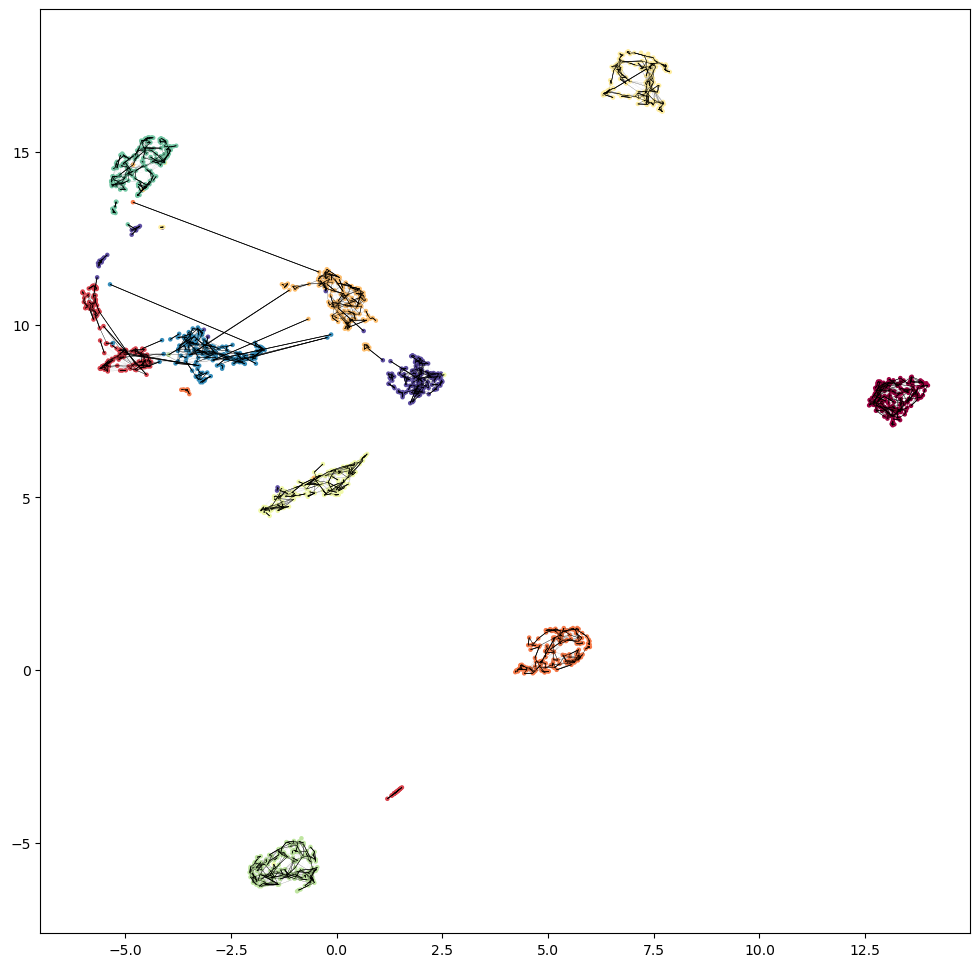

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = graph.tocoo()
edges = LineCollection(
    np.dstack([mapper.embedding_[coo_umap_graph.row], mapper.embedding_[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=np.clip(1e0 * coo_umap_graph.data, 0, 0.5),
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), np.clip(1e1 * coo_umap_graph.data, 0, 1)]).T,
    zorder=3
)
ax.add_collection(edges)
ax.scatter(*mapper.embedding_.T, s=5, c=digits.target, cmap="Spectral", zorder=0)

In [14]:
coo_umap_graph.data

array([0.07248314, 0.00108359, 0.00903398, ..., 0.00851434, 0.7120255 ,
       0.02045546], dtype=float32)

In [15]:
np.bincount(scipy.sparse.csgraph.connected_components(graph)[1])

array([177, 266,  10, 162, 169, 132, 177, 168,  63, 151, 181,   4,   1,
         5,   2,  11,  16,   9,   3,  24,   3,  13,   6,   5,   2,   3,
         1,   1,   1,   3,   1,   2,   4,   6,   1,   2,   4,   2,   2,
         1,   1,   2])

In [16]:
import sklearn.metrics

In [17]:
sklearn.metrics.adjusted_rand_score(digits.target, scipy.sparse.csgraph.connected_components(graph)[1])

0.8123312339380179

In [18]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, scipy.sparse.csgraph.connected_components(graph)[1])

0.8670570200504311